In [1]:
import cv2
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import imageio
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from UtilityTest import DepthDataset
from UtilityTest import ToTensor

In [2]:
# clean folder data before saving video data    

# dir = './Demo/src_video'
# for f in os.listdir(dir):
#     os.remove(os.path.join(dir,f))

In [3]:
Location_video='./Demo/src_video/IMG_9994.MOV'

In [4]:
#converting video into frames
dir = './Demo/video_frames'
for f in os.listdir(dir):
    os.remove(os.path.join(dir,f))

vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("./Demo/video_frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

0 (1080, 1920)
1 (1080, 1920)
2 (1080, 1920)


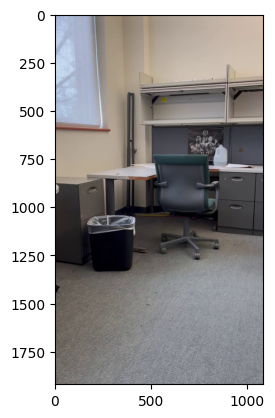

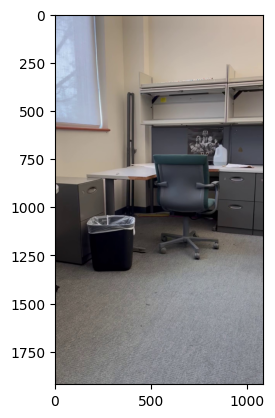

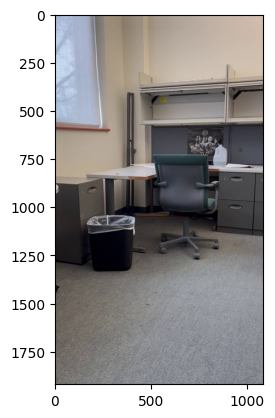

<Figure size 640x480 with 0 Axes>

In [5]:
#location of video frames
loc_img='./Demo/video_frames'

#ploting few sample frames
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size)


    plt.imshow(sample['image'])
    plt.figure()


    if i == 2:
        plt.show()
        break

In [6]:
depth_dataset = DepthDataset(root_dir=loc_img,transform=transforms.Compose([ToTensor()]))
# depth_dataset
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
# train_loader
dataiter = iter(train_loader)
images = next(dataiter)


In [7]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
from Mobile_model import Model
model = Model().cuda()
# model = nn.DataParallel(model)
#loading the the trained model
model.load_state_dict(torch.load('./model/26.pth'))
model.eval()


/home/leo_wsl/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo_wsl/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (encoder): Encoder(
    (original_model): MobileNetV2(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Con

In [8]:
# Display sample model output

torch.Size([1, 3, 480, 640])
torch.Size([240, 320])


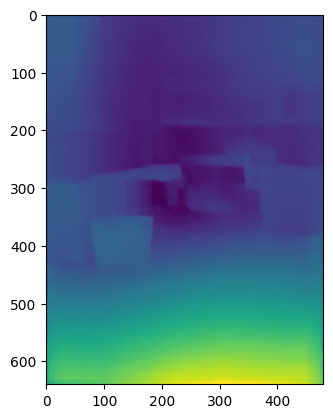

In [9]:
# featrues, labels = images
device = torch.device('cuda:0')

print(images['image'].shape)
currImage = images['image'].to(device)

output = model(currImage)
output = output.reshape(240,320)

print(output.shape)

output = output.detach().cpu().numpy()

# resize to normal camera image
output = cv2.resize(output, (480,640))
plt.imshow(output)
plt.show()

In [10]:
#generating the depth image of frames
import matplotlib.cm as cm

dir = './Demo/depth_frames'
for f in os.listdir(dir):
    os.remove(os.path.join(dir,f))

previousImage = None
threshold = 10000

for i, image in enumerate(depth_dataset):        
    x = torch.autograd.Variable(torch.reshape(image['image'], (1, 3, 480, 640)).cuda())
    output = model(x).detach().cpu().numpy()
    output = 1000/output
    
    output=output.reshape(240,320)
    img=output
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.resize(resized, (480,640))
    plt.imsave('./Demo/depth_frames/geeks%d.jpg' %i, resized)

In [11]:
from os.path import isfile, join
 
    
dir = './Demo/depth_video'
for f in os.listdir(dir):
    os.remove(os.path.join(dir,f))
    
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    # print(files)

    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
 

In [12]:
    #convert frames to videos
    pathIn= './Demo/depth_frames/'
    pathOut = './Demo/depth_video/video1.mp4'
    #enter the correct frame rates
    fps = 30.01
    convert_frames_to_video(pathIn, pathOut, fps)

./Demo/depth_frames/geeks0.jpg
./Demo/depth_frames/geeks1.jpg
./Demo/depth_frames/geeks2.jpg
./Demo/depth_frames/geeks3.jpg
./Demo/depth_frames/geeks4.jpg
./Demo/depth_frames/geeks5.jpg
./Demo/depth_frames/geeks6.jpg
./Demo/depth_frames/geeks7.jpg
./Demo/depth_frames/geeks8.jpg
./Demo/depth_frames/geeks9.jpg
./Demo/depth_frames/geeks10.jpg
./Demo/depth_frames/geeks11.jpg
./Demo/depth_frames/geeks12.jpg
./Demo/depth_frames/geeks13.jpg
./Demo/depth_frames/geeks14.jpg
./Demo/depth_frames/geeks15.jpg
./Demo/depth_frames/geeks16.jpg
./Demo/depth_frames/geeks17.jpg
./Demo/depth_frames/geeks18.jpg
./Demo/depth_frames/geeks19.jpg
./Demo/depth_frames/geeks20.jpg
./Demo/depth_frames/geeks21.jpg
./Demo/depth_frames/geeks22.jpg
./Demo/depth_frames/geeks23.jpg
./Demo/depth_frames/geeks24.jpg
./Demo/depth_frames/geeks25.jpg
./Demo/depth_frames/geeks26.jpg
./Demo/depth_frames/geeks27.jpg
./Demo/depth_frames/geeks28.jpg
./Demo/depth_frames/geeks29.jpg
./Demo/depth_frames/geeks30.jpg
./Demo/depth_frame

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [13]:
#converting the frames to gif

filenames='./Demo/depth_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
        images.append(imageio.imread(os.path.join('./Demo/depth_frames/',filename)))
        print(filename)
imageio.mimsave('./Demo/depth_video/movie_depth.gif', images)

/tmp/ipykernel_3986/3812648670.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('./Demo/depth_frames/',filename)))


geeks0.jpg
geeks10.jpg
geeks20.jpg
geeks30.jpg
geeks40.jpg
geeks50.jpg
geeks60.jpg
geeks70.jpg
geeks80.jpg
geeks90.jpg
geeks100.jpg
geeks110.jpg
geeks120.jpg
geeks130.jpg
geeks140.jpg
geeks150.jpg
geeks160.jpg
geeks170.jpg
geeks180.jpg
geeks190.jpg
geeks200.jpg
geeks210.jpg
geeks220.jpg
geeks230.jpg
geeks240.jpg


In [17]:
from skimage import transform,io
filenames='./Demo/video_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(os.path.splitext(x)[0]))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
            # resize to 28x28
        grey=(imageio.imread(os.path.join('./Demo/video_frames/',filename)))
        image = transform.resize(grey, (480,640), mode='symmetric', preserve_range=True)
        resized = cv2.resize(image, (480,640))
        images.append(resized)
        print(filename)
imageio.mimsave('./Demo/depth_video/movie_real.gif', images)

/tmp/ipykernel_3986/2485997259.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grey=(imageio.imread(os.path.join('./Demo/video_frames/',filename)))


0.jpg
10.jpg
20.jpg
30.jpg
40.jpg
50.jpg
60.jpg
70.jpg
80.jpg
90.jpg
100.jpg
110.jpg
120.jpg
130.jpg
140.jpg
150.jpg
160.jpg
170.jpg
180.jpg
190.jpg
200.jpg
210.jpg
220.jpg
230.jpg


Lossy conversion from float64 to uint8. Range [0.0, 246.82190809501654]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 248.20214188765132]. Convert image to uint8 prior to saving to suppress this warning.


240.jpg


Lossy conversion from float64 to uint8. Range [0.0, 249.98288612746805]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 245.354155839711]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 246.85428441014986]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 230.50375938841685]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 230.10045691885944]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 231.8384033193255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 232.16389002574155]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint